# NSF Research Awards Abstracts

### Instructions

This dataset comprises several paper abstracts, one per file, that were furnished by the NSF
(National Science Foundation). A sample abstract is shown at the end.
Your task is developing an unsupervised model which classifies abstracts into a topic (discover
them!). Indeed, your goal is to group abstracts based on their semantic similarity.
You can get a sample of abstracts here. Be creative and state clearly your approach. Although
we don’t expect accurate results we want to identify your knowledge over traditional and newest
method over NLP

### 0 - Introduction

Topic modeling is one of several used NLP techniques which is frequently applied in document retrieval, personalizing content, trends identification.  Top modeling has four principal methods for topic extraction: LDA, NMF, Top2Vec and BERTopic.  

    Latent Dirichlet Allocation (LDA):  is an unsupervised technique for uncovering hidden topics within a document. By using Dirichlet distributions, LDA represents documents as distributions of topics and topics as distributions of words based on their frequency in the corpus. LDA assumes that each document contains a mixture of topics, and that each topic is a mixture of words that are associated with each other.

    Non-Negative Matrix Factorization (NMF):  is a linear algebra algorithm used to uncover hidden topics by decomposing high-dimensional vectors into non-negative, lower-dimensional representations. Given a normalized TF-IDF matrix as input, NMF outputs two matrices: a matrix of words by topics and a matrix of topics by documents.  Through multiple iterations, NMF optimizes the product of these two matrices until it reaches the original TF-IDF matrix.

    Top2Vec:  automatically detects high density areas of documents in its semantic space, the centroids of which are identified as the prominent topics in the corpora. Top2Vec assumes that each document is based on one topic, instead of a mixture of topics.

    BERTopic: Like Top2Vec, BERTopic uses BERT embeddings and a class-based TF-IDF matrix to discover dense clusters in the document corpora. These dense clusters allow for easily interpretable topics while keeping the most important words in the topic description.


For the solution of this challenge I opted to use a modification of the BERTopic for a better validation of the steps and results.  In the next paragraphs each of the steps required for the topic extraction will be described.

.

### 1. First steps in code

In this part the libraries required for the different steps are implemented: extraction of the abstracts from the xml, transformation of sentences to vectors, comparissons among vectors, etc.

In [1]:
import pandas as pd                                             #2.0.1
import os                                                       #nt
import xml.etree.cElementTree as et                             #1.3.0
import umap                                                     #0.5.5
import hdbscan                                                  #0.8.33
import matplotlib.pyplot as plt                                 #3.8.3
import numpy as np                                              #1.24.3
from sklearn.feature_extraction.text import CountVectorizer     #0.0.2
from sentence_transformers import SentenceTransformer           #2.4.0
from sklearn.metrics.pairwise import cosine_similarity          #0.1.2

.

### 2. Abstracts cleanning and formatting

Even when methods as BERTopic do not required preprocessing (stop words removal, tokenization, stemming, lemmatization, etc), it is necessary to extract all the xml remnants in the paragraphs.  Also, embedding process requires that abstracts must be presented as a list.  Next cell cleans the abstracts, remove the ones without narration and prepares the list.

In [2]:
def xml_cleaning_text(text):
    text = text.replace("&lt;br/&gt;", "") 
    text = text.replace("ltbrgt", "") 
    return text


test_list = []
path = 'C:/Users/LENOVO/Downloads/2020'
for filename in os.listdir(path):
    abstract = ""
    if not filename.endswith('.xml'): continue
    fullname = os.path.join(path, filename)
    tree=et.parse(fullname)
    root=tree.getroot()
    for abstr in root.iter('AbstractNarration'):
        abstract = abstr.text
    if abstract != None: 
        abstract = xml_cleaning_text(abstract)
        index = len(test_list)
        test_list.insert(index, abstract)

In [3]:
#test_list

Once that abstracts were processed in this small procedure, now it follows the embedding procedure.

.

### 3. Pretrained model selection

Sentence_transformers framework provides an easy method to compute dense vector representations for sentences, paragraphs, and images. The models are based on transformer networks like BERT / RoBERTa / XLM-RoBERTa etc. and achieve state-of-the-art performance in various tasks. Text is embedded in vector space such that similar text are closer and can efficiently be found using cosine similarity.

For this experiment I use three different pretrained models.  At the end, all-MiniLM-L12-v2 resulted to have a great embedding performance, with a reasonable speed and compact size.  For a better reference of the pretrained models please verify the link https://www.sbert.net/docs/pretrained_models.html

Sentence_transformers provide a large list of Pretrained Models for more than 100 languages. Some models are general purpose models, while others produce embeddings for specific use cases. Pre-trained models can be loaded by just passing the model name: SentenceTransformer('model_name').

In [4]:
#model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
#model = SentenceTransformer('all-mpnet-base-v2')
model = SentenceTransformer('all-MiniLM-L12-v2')

### 4. Embedding procedure

The next step is converting the documents to numerical data. I used BERT for this purpose as it extracts different embeddings based on the context of the word.  After this step, each of the abstracts are transformed to 384-dimensional vectors.

In [5]:
embedding = model.encode(test_list, show_progress_bar=True)
print(embedding)

Batches:   0%|          | 0/412 [00:00<?, ?it/s]

[[-0.06460923 -0.0167403  -0.06319063 ...  0.0333287   0.1363133
   0.0490967 ]
 [ 0.01023794  0.03461026  0.10262935 ...  0.02458825  0.06760587
   0.05256987]
 [-0.09768373  0.04657663  0.02220079 ... -0.04947853 -0.01443587
  -0.01266193]
 ...
 [-0.01629216  0.07713658 -0.035082   ...  0.02813233  0.00547994
   0.00772742]
 [-0.01629216  0.07713658 -0.035082   ...  0.02813233  0.00547994
   0.00772742]
 [ 0.0609619  -0.04905521 -0.01625699 ... -0.05161207  0.03077687
  -0.01193994]]


It is necessary to validate that similar topics are clustered together such that we can find the topics within these clusters. Before that, we need to lower the dimensionality of the vectors.

### 5. UMAP (Uniform Manifold Approximation and Projection)

UMAP package help us to reduce the dimensionality while keeping the size of the local neighborhood:

In [6]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embedding)

### 6. HDBSAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise)

HDBSCAN learns the context of the language and identifies high density regions within a document corpora based on their word distributions to deduce the optimal number of topics.

In [7]:
cluster = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

Now we have clustered similar documents together which should represent the topics that they consist of. To visualize the resulting clusters we can reduce the dimensionality to 2:

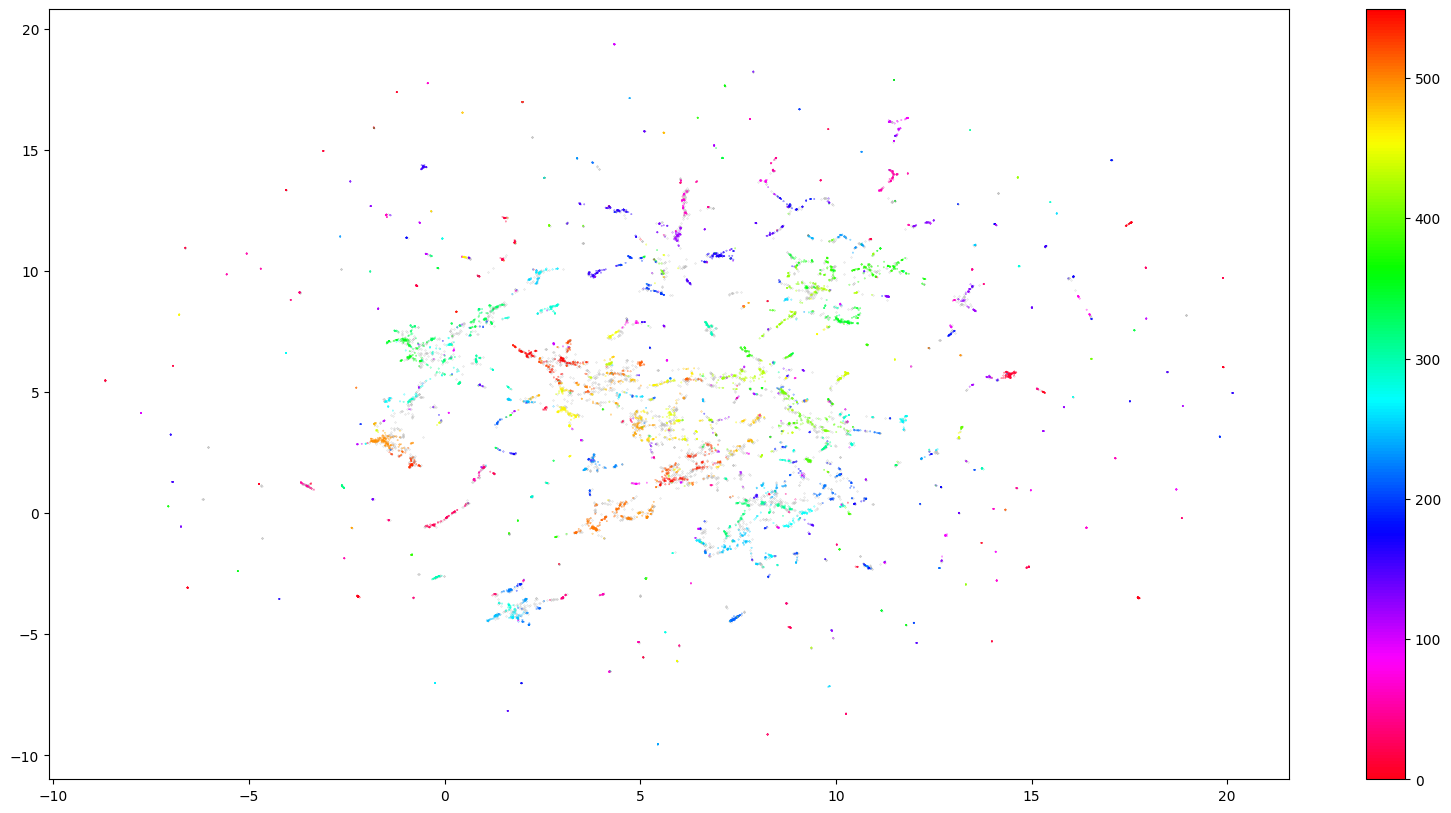

In [8]:
umap_data = umap.UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embedding)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

At the end of this step, result dataframe shows the label of each abstract (cluster number) and their respective coordinates:

In [9]:
result

,x,y,labels
0,6.122447,3.070902,-1
1,0.979171,6.451790,-1
2,2.026649,-2.745803,187
3,0.755273,7.977842,336
4,-2.568400,1.036013,316
...,...,...,...
13154,8.669034,4.946033,406
13155,1.883094,-4.330270,250
13156,10.135426,0.363672,82
13157,10.146456,0.341982,82


### 7. Topic creation

If it is used a variant of TF-IDF , that would allow me to extract what makes each set of documents unique compared to the other.  To create this class-based TF-IDF score, we need to first create a single document for each cluster of documents:

In [10]:
docs_df = pd.DataFrame(test_list, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

The frequency of each word is extracted for each class and divided by the total number of words. This action can be seen as a form of regularization of frequent words in the class. Next, the total, unjoined, number of documents is divided by the total frequency of words across all classes.

In [11]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    tf_idf = np.nan_to_num(tf_idf)
    return tf_idf, count

  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(test_list))

With this function now we have a single importance value for each word in a cluster which can be used to create the topic. If we take the top 5 most important words in each cluster, then we would get a good representation of a cluster, and thereby a topic.

In [12]:
tf_idf

array([[6.79156857e-04, 0.00000000e+00, 0.00000000e+00, ...,
        6.01803983e-04, 0.00000000e+00, 4.86070534e-04],
       [9.05546034e-06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.39369348e-06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.05546034e-06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.05546034e-06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.67873870e-05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### 8. Topic representation

In order to create a topic representation, we take the top 20 words per topic based on their c-TF-IDF scores. The higher the score, the more representative it should be of its topic as the score is a proxy of information density.

In [13]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,4123
498,497,147
170,169,107
215,214,105
11,10,101
159,158,99
351,350,99
250,249,86
459,458,81
507,506,73


The topic name-1 refers to all documents that did not have any topics assigned. The great thing about HDBSCAN is that not all documents are forced towards a certain cluster. If no cluster could be found, then it is simply an outlier.  This is an example of the cluster 19 and the top 10 words:

In [14]:
top_n_words[19][:10]

[('perovskite', 0.07050847300640571),
 ('perovskites', 0.04300865799960173),
 ('solar', 0.04170522351894684),
 ('chalcogenide', 0.02528901373902579),
 ('halide', 0.021860856679320775),
 ('cells', 0.019871528118606055),
 ('device', 0.015892195874652685),
 ('tin', 0.014897473859503478),
 ('carrier', 0.01431632013075127),
 ('inorganic', 0.014124521637111209)]

### 9. Topic reduction

One practical step is the reduction of topics, which consist in the reduction of the topics number by merging the topic vectors that were most similar to each other.

We can use a similar technique by comparing the c-TF-IDF vectors among topics, merge the most similar ones, and finally re-calculate the c-TF-IDF vectors to update the representation of our topics:

In [15]:
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(test_list)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)
topic_sizes = topic_sizes.sort_values(by='Topic')


The next cell is just a preparation of the format.  The final dataframe contains the name of the topic, its size and the cluster name consisting in the concatenation of the first five topics.

In [16]:
topic_null_size = topic_sizes.loc[0,'Size']
topic_sizes = topic_sizes.drop(topic_sizes.index[0])
topic_sizes['Cluster_name'] = '0'
topic_sizes.loc[-1,'Cluster_name'] = 'ABSTRACTS-WITHOUT-CLUSTER'
topic_sizes.loc[-1,'Topic'] = '-1'
topic_sizes.loc[-1,'Size'] = topic_null_size
for i in range(0,len(topic_sizes)-1):
    topic_sizes.loc[i+1,'Cluster_name'] = str(top_n_words[i][:5][0][0])+" - "+str(top_n_words[i][:5][1][0])+" - "+str(top_n_words[i][:5][2][0])+" - "+str(top_n_words[i][:5][3][0])+" - "+str(top_n_words[i][:5][4][0])
topic_sizes = topic_sizes.sort_values(by='Size')

In [17]:
topic_sizes = topic_sizes.sort_values(by='Size', ascending=False)
topic_sizes

,Topic,Size,Cluster_name
-1,-1,4143.0,ABSTRACTS-WITHOUT-CLUSTER
482,481.0,147.0,covid - pandemic - 19 - social - risk
167,166.0,107.0,archaeological - heritage - ancient - archaeol...
212,211.0,105.0,income - graduation - scholarships - scholars ...
11,10.0,101.0,plasma - ionospheric - ionosphere - solar - space
...,...,...,...
126,125.0,6.0,floodplain - flood - floodplains - regulatory ...
387,386.0,6.0,flybase - drosophila - fly - dssc - scea
189,188.0,6.0,deepfake - deepfakes - journalists - content -...
436,435.0,5.0,active - enzymes - particles - powered - futur...


### 10. Conclusions

The aim of this code was to develope an unsupervised model which classifies abstracts into a topic based on their semantic similarity.  There are some comments about the presented code:

    The use of the sentence-transformer package was crucial to this task.  It generated high-quality embeddings.

    Pre-trained model was selected according to the speed and performance; however there were not exhaustive tests to assure that it is not the best of the options.

    HDBSAN is a great option for the detection of topics because it does not force data points to clusters as it considers them outliers.

    I decided to use just the principal 5 words for the topic definition, but it could use more words and it would offer a better description of the cluster.
    
    Topic reduction could be not strictly necessary.  I considered that due to the redundancy in some of the clusters it would be a good idea to maintain a low count of clusters.

.

### 11. References

    Deerwester, S. (1990). Indexing by latent semantic analysis. Retrieved from Asis&t: https://asistdl.onlinelibrary.wiley.com/doi/abs/10.1002/(SICI)1097-4571(199009)41:6%3C391::AID-ASI1%3E3.0.CO;2-9

    Hofmann, T. (1999). Probabilistic latent semantic analysis. Retrieved from ACM: https://dl.acm.org/doi/10.5555/2073796.2073829

    Blei, D. (2003). Latent Dirichlet Allocation. Retrieved from Journal of ML Research: https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf

    Angelov, D. (2020). Top2Vec: Distributed Representations of Topics. Arxiv.

    Briggs, J. (n.d.). Advanced Topic Modeling with BERTopic. Retrieved from Pinecone: https://www.pinecone.io/learn/bertopic/

    David, D. (2021, August 24). NLP Tutorial: Topic Modeling in Python with BerTopic. Retrieved from hackernoon: https://hackernoon.com/
    nlp-tutorial-topic-modeling-in-python-with-bertopic-372w35l9

    Grootendorst, M. (2020, October 5). Topic Modeling with BERT.  Leveraging BERT and TF-IDF to create easily interpretable topics. Retrieved from Towards Data Science: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

    Grootendorst, M. (2021, January 6). Interactive Topic Modeling with BERTopic.  An ind-depth guide to topic modeling with BERTopic. Retrieved from Towards Data Science: https://towardsdatascience.com/interactive-topic-modeling-with-bertopic-1ea55e7d73d8
   
